In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import numpy as np
import verde as vd

In [2]:
data = vd.datasets.fetch_rio_magnetic_anomaly()
region = vd.get_region(data.longitude, data.latitude)
print("Data region:", region)

Data region: (-42.599990999999996, -42.000015000000005, -22.5, -22.000014999999998)


In [40]:
%%time
spacing = 0.5/60
lon, lat, total_field = vd.block_reduce(data.longitude, data.latitude,
                                        data.total_field_anomaly_nt, 
                                        reduction=np.mean, spacing=spacing)
print(total_field.size)

3648
CPU times: user 3.86 s, sys: 2.59 ms, total: 3.86 s
Wall time: 3.88 s


In [11]:
# Project the data using pyproj so that we can use it as input for the gridder.
# We'll set the latitude of true scale to the mean latitude of the data.
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())
coordinates = projection(lon, lat)

In [45]:
%%time
# Now we can set up a gridder for the decimated data
#grd = vd.Spline()
grd = vd.Spline(spacing=spacing*2*1e5)
grd.fit(coordinates, total_field)
print("Gridder used:", grd)

Gridder used: Spline(damping=None, fudge=1e-05, shape=None, spacing=1666.6666666666667)
CPU times: user 6.81 s, sys: 2.44 s, total: 9.25 s
Wall time: 1.66 s


In [46]:
grd.force_.size

1292

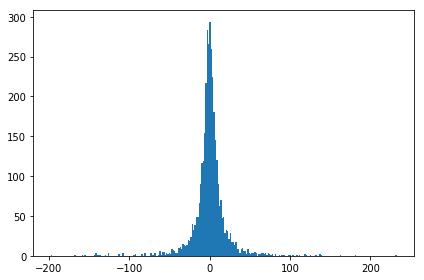

In [42]:
plt.hist(grd.residual_, bins='auto')
plt.tight_layout()

In [43]:
grid = grd.grid(region=region, spacing=spacing, projection=projection,
                dims=['latitude', 'longitude'], data_names=['total_field'])
print("Generated geographic grid:")
print(grid)

Generated geographic grid:
<xarray.Dataset>
Dimensions:      (latitude: 61, longitude: 73)
Coordinates:
  * longitude    (longitude) float64 -42.6 -42.59 -42.58 -42.57 -42.57 ...
  * latitude     (latitude) float64 -22.5 -22.49 -22.48 -22.48 -22.47 -22.46 ...
Data variables:
    total_field  (latitude, longitude) float64 159.4 135.4 115.6 126.2 128.2 ...
Attributes:
    metadata:  Generated by Spline(damping=None, fudge=1e-05, shape=None, spa...


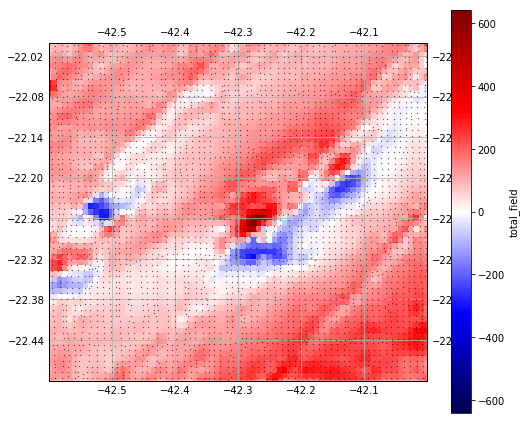

In [44]:
# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

plt.figure(figsize=(7, 6))
# Make a Mercator map of our gridded bathymetry
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Gridded Bathymetry Using Scipy", pad=25)
# Plot the gridded bathymetry
grid.total_field.plot.pcolormesh(ax=ax, transform=crs, cmap='seismic')
# Plot the locations of the decimated data
ax.plot(lon, lat, '.k', markersize=0.5, transform=crs)
ax.set_extent(region, crs=crs)
ax.gridlines(draw_labels=True)
plt.tight_layout()
plt.show()